### Leveraging explanation quality for model selection

In this notebook we are going to explore how, using **teex**, we can improve our model selection procedures (following [Jia et al. (2021)](https://dl.acm.org/doi/abs/10.1007/978-3-030-86520-7_43)).

#### 0. Approach

Intuitively, a model that has a good predictive performance and makes decisions based on reasonable evidence is better than one that achieves the same level of accuracy but makes decisions based on circumstantial evidence. So, given an explanation model, we can investigate which evidence a model is basing its decisions on: a set of explanations will be of quality if it's based on reasonable evidence and of low quality otherwise. Then, given two models with similar predictive performance, we can leverage whether or not it is basing its decisions on good or bad evidence. With this intuition, we define a model scoring mechanism:

$$ score(f) = \alpha \cdot \text{score}_{acc}(f) + (1 - \alpha)\cdot \text{score}_{\text{explanation}}(f)$$

where $\alpha$ $\in[0, 1]$ is a hyperparameter, $f$ is the model being assessed and $\text{score}_{acc}(f)$ and $\text{score}_{\text{explanation}}(f)$ are accuracy and explanation scores, respectively. All models $f_1, ..., f_n$ will be assigned a score and we will choose based on it. **teex** will help us compute $\text{score}_{\text{explanation}}(f)$.

In [443]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy

import random
random_state = 888
random.seed(random_state)

from teex import saliencyMap
from sklearn import metrics, model_selection
from captum import attr
from captum.attr import visualization as viz
from torch import optim
from torchvision import models, transforms
from torch.utils import data

#### 1. Getting the data

We are going to work with a subset of the Oxford-IIIT Pet dataset, included in **teex**. It contains roughly 7000 images from 37 categories.

In [444]:
oxford_data = saliencyMap.data.OxfordIIIT()

We have the following classes available

In [445]:
oxford_data.classMap

{0: 'cat_Abyssinian',
 1: 'dog_american_bulldog',
 2: 'dog_american_pit_bull_terrier',
 3: 'dog_basset_hound',
 4: 'dog_beagle',
 5: 'cat_Bengal',
 6: 'cat_Birman',
 7: 'cat_Bombay',
 8: 'dog_boxer',
 9: 'cat_British_Shorthair',
 10: 'dog_chihuahua',
 11: 'cat_Egyptian_Mau',
 12: 'dog_english_cocker_spaniel',
 13: 'dog_english_setter',
 14: 'dog_german_shorthaired',
 15: 'dog_great_pyrenees',
 16: 'dog_havanese',
 17: 'dog_japanese_chin',
 18: 'dog_keeshond',
 19: 'dog_leonberger',
 20: 'cat_Maine_Coon',
 21: 'dog_miniature_pinscher',
 22: 'dog_newfoundland',
 23: 'cat_Persian',
 24: 'dog_pomeranian',
 25: 'dog_pug',
 26: 'cat_Ragdoll',
 27: 'cat_Russian_Blue',
 28: 'dog_saint_bernard',
 29: 'dog_samoyed',
 30: 'dog_scottish_terrier',
 31: 'dog_shiba_inu',
 32: 'cat_Siamese',
 33: 'cat_Sphynx',
 34: 'dog_staffordshire_bull_terrier',
 35: 'dog_wheaten_terrier',
 36: 'dog_yorkshire_terrier'}

We are going to work in a binary setting, so let us choose two cat targets.

In [446]:
imSi, labSi, exSi = oxford_data.get_class_observations(32) # Siamese cats
imSp, labSp, exSp = oxford_data.get_class_observations(33) # Sphynx cats

(-0.5, 499.5, 374.5, -0.5)

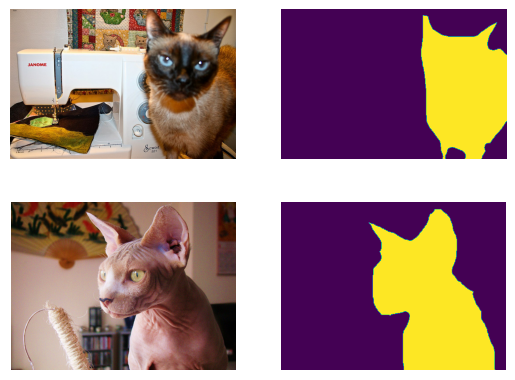

In [447]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(np.array(imSi[5]))
axarr[0,0].axis("off")
axarr[0,1].imshow(np.array(exSi[5]))
axarr[0,1].axis("off")
axarr[1,0].imshow(np.array(imSp[4]))
axarr[1,0].axis("off")
axarr[1,1].imshow(np.array(exSp[4]))
axarr[1,1].axis("off")

#### 2. Declaring our classifiers

We create a common model class that will help us perform the experiments and implement its logic. We use teex in the evaluation functions.

In [448]:
class Model:
    """ Our Model class. Training will be performed with 50 epochs, 
    batch size of 16, learning rate of 0.001 and momentum 0.9. """
    
    def __init__(self, modelName: str, model: torch.nn.Module, 
                 input_size: int, random_state: int = 888) -> None:
        self.modelName = modelName
        self.model = model
        self.random_state = random_state
        self.input_size = input_size
        
        self._trained = False
        self._valid_explainers = ("ggcam", "sal", "gshap", "bp")
        self._latent_explainers = {
            "ggcam": attr.GuidedGradCam,
            "sal": attr.Saliency,
            "gshap": attr.GradientShap, 
            "bp": attr.GuidedBackprop
        }
        self._lr = 0.001
        self._n_epochs = 50
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._optim_momentum = 0.9
        self._optimizer = optim.SGD(self.model.parameters(), lr=self._lr, momentum=self._optim_momentum)
        self._criterion = torch.nn.CrossEntropyLoss()
        
    def train(self, dataloaders: dict, verbose=True) -> None:
        
        if self._trained:
            raise Exception("Model is already trained.")

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0

        for epoch in range(self._n_epochs):
            if verbose:
                print('Epoch {} / {}'.format(epoch + 1, self._n_epochs))
                print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(self._device)
                    labels = labels.to(self._device)

                    # zero the parameter gradients
                    self._optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        outputs = self.model(inputs)
                        loss = self._criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            self._optimizer.step()

                    running_loss += loss.item() / inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print(f"{self.modelName} {phase} Loss {epoch_loss:.4f} Acc {epoch_acc:.4f}")

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())

        self.model.load_state_dict(best_model_wts)
        self._trained = True
    
    def get_explanations(self, X, method: str = "sal", expParams: dict = None) -> np.ndarray:
        if self._check_is_trained() and self._check_explainer(method):
            if expParams is None:
                expParams = {}
            explainer = self._get_explainer(method, **expParams)
            pred_labels = self.get_predictions(X)
            exps = explainer.attribute(X, pred_labels)
            exps = [np.abs(viz._normalize_image_attr(np.swapaxes(exp.numpy(), 0, 2), 'positive', 2)) for exp in exps]
            return np.stack(exps)
        
    def get_predictions(self, X):
        if self._check_is_trained():
            _ , preds = torch.max(self.model(X), dim=1)
            return preds
    
    def compute_acc(self, gtY, y) -> float:
        scores = metrics.accuracy_score(y, gtY)
        return np.mean(scores)
    
    def compute_exp_score(self, gtExps, predExps) -> float:
        return saliencyMap.eval.saliency_map_scores(gtExps, predExps, metrics="auc")
    
    def compute_total_score(self, 
                            y: np.ndarray, 
                            gtY: np.ndarray, 
                            exps: np.ndarray, 
                            gtExps: np.ndarray,
                            alpha: float) -> float:
        
        return alpha * self.compute_acc(gtY, y) + (1 - alpha) * self.compute_exp_score(gtExps, exps)
    
    def _check_is_trained(self) -> bool:
        if self._trained:
            return True
        else:
            raise Exception("Model is not trained yet!")
        
    def _check_explainer(self, exp: str) -> bool:
        if exp not in self._valid_explainers:
            raise ValueError(f"Explainer {exp} is not valid. ({self._valid_explainers})")
        else:
            return True
        
    def _get_explainer(self, exp: str, **kwargs) -> bool:
        if kwargs is not None:
            explainer = self._latent_explainers[exp](self.model, **kwargs)
        else:
            explainer = self._latent_explainers[exp](self.model)
            
        return explainer

We then get 2 pre-trained models, modify them to our usecase and initialize them.

In [449]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

# SqueezeNet
sqz = models.squeezenet1_0(weights="DEFAULT")
set_parameter_requires_grad(sqz)
sqz.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
sqz.num_classes = 2
input_size = 224

squeezeNet = Model("SqueezeNet", sqz, input_size)

#### 3. Preparing our data

Now, we are going to incorporate our data into a `torch.Dataset`, for easy batching and loading.
We also create the data splits and transform the observations to the model's required input size.

In [450]:
class DemoData(data.Dataset):
    
    def __init__(self, data, labels) -> None:
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, slice):
        return self.data[slice], self.labels[slice]


def transform(images, input_size, normalize=True):
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size)
    ])
    
    if normalize:
        norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        d = [norm(transform(im)) for im in images]
    else:
        d = [transform(im) for im in images]
    return torch.stack(d, axis=0)


indexes = random.sample(list(range(len(imSi) + len(imSp))), len(imSi) + len(imSp))
ims, labs, exps = (imSi + imSp, labSi + labSp, exSi + exSp)

original_images = transform([ims[idx] for idx in indexes], input_size, normalize=False)
ims = transform([ims[idx] for idx in indexes], input_size, normalize=True)
# transform labels from their class ID to 1 and 0
labs = torch.LongTensor([0 if labs[idx] == 32 else 1 for idx in indexes])
exps = np.squeeze(transform([exps[idx] for idx in indexes], input_size, normalize=False).numpy())

demo_data = DemoData(ims, labs)

we create the dataloaders. We are using a 50 / 25 / 25 split and a batch size of 25.

In [451]:
train_idx, test_idx = model_selection.train_test_split(list(range(len(ims))), train_size=0.75, random_state=random_state)
train_idx, val_idx = model_selection.train_test_split(train_idx, test_size=0.333, random_state=random_state)

all_data = {}
all_data['train'] = data.Subset(demo_data, train_idx)
all_data['val'] = data.Subset(demo_data, val_idx)
all_data['test'] = data.Subset(demo_data, test_idx)

all_exps = {}
all_exps['train'] = exps[train_idx]
all_exps['val'] = exps[val_idx]
all_exps['test'] = exps[test_idx]

In [452]:
dataloaders_dict = {split: data.DataLoader(all_data[split], 
                                           batch_size=10, 
                                           shuffle=True, 
                                           num_workers=0) for split in ['train', 'val', 'test']}

In [ ]:
squeezeNet.train(dataloaders_dict)

With the model trained, we can perform predictions and evaluate them:

In [454]:
test_preds = squeezeNet.get_predictions(all_data['test'][:][0])
test_acc = squeezeNet.compute_acc(test_preds, all_data['test'][:][1])
print(f"{round(test_acc * 100, 2)}% of test accuracy.")

98.0% of test accuracy.


In [455]:
pred_exps = squeezeNet.get_explanations(all_data['test'][:][0])

/Users/chuschus/Documents/teex/venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


We can also compute explanations with different explanation methods:

Text(0.5, 1.0, 'Predicted explanation')

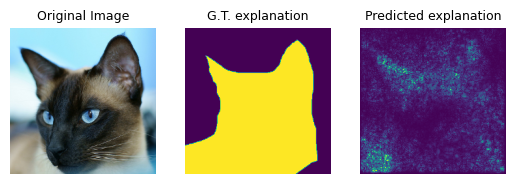

In [467]:
def swap_to_original(im):
    """ Swap np.array from C*H*W to H*W*C or from W*H to H*W"""
    if len(im.shape) > 2:
        return np.swapaxes(np.swapaxes(im, 0, 2), 0, 1)
    else:
        return np.swapaxes(im, 0, 1)

i = 2
f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.array(swap_to_original(original_images[test_idx][i])))
axarr[0].axis("off")
axarr[0].set_title('Original Image', fontsize=9)

axarr[1].imshow(np.array(all_exps['test'][i]))
axarr[1].axis("off")
axarr[1].set_title('G.T. explanation', fontsize=9)

axarr[2].imshow(swap_to_original(pred_exps[i]))
axarr[2].axis("off")
axarr[2].set_title('Predicted explanation', fontsize=9)

Now we are ready for the experiments.

#### 4. Performing the experiments

In [468]:
# WIP...